<a href="https://colab.research.google.com/github/maverick98/Group4Capstone/blob/main/Group4_ImageCaption_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
     


Sun Mar 19 15:47:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:


#Uncomment for the first time
#!pip install keras
!pip install gensim
!pip install python-levenshtein
     


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 64.9 MB/s eta 0:00:00


In [31]:
import numpy as np
import string
import tensorflow as tf
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Embedding,Dense, Layer
from tensorflow.keras.backend import softmax
from pickle import load, dump, HIGHEST_PROTOCOL
from sklearn.utils import shuffle
from numpy import savetxt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor, int64
from tensorflow.keras.layers import LayerNormalization,   ReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.metrics import Mean
from tensorflow import data, train,  reduce_sum,  equal, argmax,GradientTape, function
from tensorflow.keras.losses import sparse_categorical_crossentropy
from time import time
from pickle import dump
from tensorflow import    linalg, ones, maximum, newaxis
from tensorflow.keras import Model
from pickle import load
from tensorflow import Module
from tensorflow import   TensorArray, argmax,  transpose
from matplotlib.pylab import plt
from numpy import arange

from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
#from tqdm import tqdm
import os
import gensim
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image
import random

In [ ]:

#Uncomment for the first time.
#!wget  https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
     


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp /content/drive/MyDrive/Capstone/Flickr8k_Dataset.zip .
!cp /content/drive/MyDrive/Capstone/Flickr8k_text.zip . 


In [ ]:
!mkdir -p ./dataset/images
!mkdir -p ./dataset/texts
!unzip  /content/Flickr8k_text.zip -d ./dataset/texts
!unzip /content/Flickr8k_Dataset.zip -d ./dataset/images

PrepareDataset.py

In [11]:
class PrepareDataset:
    def __init__(self,image_path,token_file,data_limit,top_k, **kwargs):
        super().__init__(**kwargs)
        self.image_path=image_path
        self.token_file=token_file
        self.data_limit=data_limit
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
        self.tokenizer=tokenizer
        self.data=None
        self.all_img_name_vector=None
        self.all_captions=None
    def load_dataframe(self):

        file = open(self.token_file,'r')
        text = file.read()
        file.close()

        datatxt = []
        for line in text.split('\n'):
            col = line.split('\t')
            if len(col) == 1:
                continue
            w = col[0].split("#")
            datatxt.append(w + [col[1].lower()])

        data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
        data = data.reindex(columns =['index','filename','caption'])
        data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
        uni_filenames = np.unique(data.filename.values)
        self.data=data
        return data
    def show_stats(self):
        jpgs = os.listdir(self.image_path)
        print("Total Images in Dataset = {}".format(len(jpgs)))

        vocabulary = []
        for txt in self.data.caption.values:
            vocabulary.extend(txt.split())
        print('Vocabulary Size: %d' % len(set(vocabulary)))
        img = self.data["filename"].tolist()
        caption = self.data["caption"].tolist()
        print(f"len(img) : {len(img)}")
        print(f"len(caption) : {len(caption)}")

        print(f"len(all_img_name_vector) : {len(self.all_img_name_vector)}")
        print(f"len(all_captions) : {len(self.all_captions)}")

        print(f"len(img_name_vector) : {len(self.img_name_vector)}")
        print(f"len(train_captions) : {len(self.train_captions)}")

        
    # To remove punctuations
    def remove_punctuation(self,text_original):
        text_no_punctuation = text_original.translate(string.punctuation)
        return(text_no_punctuation)

    # To remove single characters
    def remove_single_character(self,text):
        text_len_more_than1 = ""
        for word in text.split():
            if len(word) > 1:
                text_len_more_than1 += " " + word
        return(text_len_more_than1)

    # To remove numeric values
    def remove_numeric(self,text):
        text_no_numeric = ""
        for word in text.split():
            isalpha = word.isalpha()
            if isalpha:
                text_no_numeric += " " + word
        return(text_no_numeric)
    def text_clean(self,text_original):
        text = self.remove_punctuation(text_original)
        text = self.remove_single_character(text)
        text = self.remove_numeric(text)
        return(text)
    def clean_data(self):
        for i, caption in enumerate(self.data.caption.values):
            newcaption = self.text_clean(caption)
            self.data["caption"].iloc[i] = newcaption
        clean_vocabulary = []
        for txt in self.data.caption.values:
            clean_vocabulary.extend(txt.split())
        print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))
    def load_all_captions(self):
        self.all_captions = []

        for caption  in self.data["caption"].astype(str):
            caption = '<start> ' + caption+ ' <end>'
            self.all_captions.append(caption)
    def load_all_image_names(self):
        self.all_img_name_vector = []
        for annot in self.data["filename"]:
            full_image_path = self.image_path + annot
            self.all_img_name_vector.append(full_image_path)
         
    def data_limiter(self):
        train_captions, img_name_vector = shuffle(self.all_captions,self.all_img_name_vector,random_state=1)
        self.train_captions = train_captions[:self.data_limit]
        self.img_name_vector = img_name_vector[:self.data_limit]
    def load_all(self):
        self.load_dataframe()
        print(self.data.head())
        self.clean_data()
        self.load_all_captions()      
        self.load_all_image_names()
        self.data_limiter()
    def load_image_model(self):
        image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
        new_input = image_model.input
        hidden_layer = image_model.layers[-1].output
        self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
        return self.image_features_extract_model
        
    def load_image(self,image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img, image_path
    
    def tokenize_captions(self):
        self.tokenizer.fit_on_texts(self.train_captions)
        train_seqs = self.tokenizer.texts_to_sequences(self.train_captions)
        self.tokenizer.word_index['<pad>'] = 0
        self.tokenizer.index_word[0] = '<pad>'
        train_seqs = self.tokenizer.texts_to_sequences(self.train_captions)
        self.cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
    def split_train_test(self,test_size=0.2):
        self.img_name_train, self.img_name_val, self.cap_train, self.cap_val = train_test_split(self.img_name_vector,
                                                                    self.cap_vector,
                                                                    test_size=test_size,
                                                                    random_state=0)
        print(len(self.img_name_train), len(self.cap_train), len(self.img_name_val), len(self.cap_val)) 

    def preprocess_images(self):
        # Get unique images
        encode_train = sorted(set(self.img_name_vector))

        # Feel free to change batch_size according to your system configuration
        image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
        image_dataset = image_dataset.map(self.load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
        image_features_extract_model=self.load_image_model()
        #Enable tqdm in Collab
        #for img, path in tqdm(image_dataset):
        for img, path in image_dataset:
            batch_features = image_features_extract_model(img)
            batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

            for bf, p in zip(batch_features, path):
                path_of_feature = p.numpy().decode("utf-8")
                #print('saving at ',path_of_feature)
                np.save(path_of_feature, bf.numpy())

    def create_dataset(self):
        BATCH_SIZE = 64
        BUFFER_SIZE = 1000
        num_steps = len(self.img_name_train) // BATCH_SIZE

        def map_func(img_name, cap):
            img_tensor = np.load(img_name.decode('utf-8')+'.npy')
            return img_tensor, cap
       
        self.dataset = tf.data.Dataset.from_tensor_slices((self.img_name_train, self.cap_train))
       
        # Use map to load the numpy files in parallel
        self.dataset = self.dataset.map(lambda item1, item2: tf.numpy_function(
                map_func, [item1, item2], [tf.float32, tf.int32]),
                num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Shuffle and batch
        self.dataset = self.dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
        self.dataset = self.dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [12]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
    assert d_model % 2 == 0
    # first d_model/2 encode row embedding and second d_model/2 encode column embedding
    row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
    angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    #apply sin and cos to odd and even indices resp.
    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
    pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights



In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
            
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


In [14]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [15]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


In [16]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, 
            look_ahead_mask=None, padding_mask=None):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        # using look ahead mask so that during self attention current query dont consider future token
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # use padding mask to avoid padded values of both enc_output and dec_input
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2


In [17]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
        self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                            for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask=None):
        # shape(x) = (batch_size,seq_len(H*W),features)
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)


In [18]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights


In [19]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
                target_vocab_size,max_pos_encoding, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,target_vocab_size,max_pos_encoding, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights


In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = cast(step, float32)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [21]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [22]:
def create_masks_decoder(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return combined_mask

In [23]:
@tf.function
def train_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    dec_mask = create_masks_decoder(tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(img_tensor, tar_inp, 
                                        True,  
                                        dec_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [24]:




num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
top_k = 5000
target_vocab_size = top_k + 1
dropout_rate = 0.1


learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)





train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

image_path = "./dataset/images/Flicker8k_Dataset/"
token_file='./dataset/texts/Flickr8k.token.txt'
data_limit=40455


prepareDataset=PrepareDataset(image_path,token_file,data_limit,top_k)
prepareDataset.load_all()
prepareDataset.preprocess_images()
prepareDataset.tokenize_captions()
prepareDataset.split_train_test()
prepareDataset.create_dataset()
prepareDataset.show_stats()

for epoch in range(30):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (img_tensor, tar)) in enumerate(prepareDataset.dataset):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))








  



  index                   filename  \
0     0  1000268201_693b08cb0e.jpg   
1     1  1000268201_693b08cb0e.jpg   
2     2  1000268201_693b08cb0e.jpg   
3     3  1000268201_693b08cb0e.jpg   
4     4  1000268201_693b08cb0e.jpg   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  
Clean Vocabulary Size: 8357
87910968/87910968 [==============================] - 6s 0us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


32364 32364 8091 8091
Total Images in Dataset = 16182
Vocabulary Size: 8357
len(img) : 40455
len(caption) : 40455
len(all_img_name_vector) : 40455
len(all_captions) : 40455
len(img_name_vector) : 40455
len(train_captions) : 40455
Epoch 1 Batch 0 Loss 8.6384 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.1250 Accuracy 0.0187
Epoch 1 Batch 100 Loss 7.6947 Accuracy 0.0249
Epoch 1 Batch 150 Loss 7.3880 Accuracy 0.0275
Epoch 1 Batch 200 Loss 7.1042 Accuracy 0.0302
Epoch 1 Batch 250 Loss 6.8346 Accuracy 0.0337
Epoch 1 Batch 300 Loss 6.5909 Accuracy 0.0376
Epoch 1 Batch 350 Loss 6.3803 Accuracy 0.0412
Epoch 1 Batch 400 Loss 6.1910 Accuracy 0.0447
Epoch 1 Batch 450 Loss 6.0203 Accuracy 0.0482
Epoch 1 Batch 500 Loss 5.8734 Accuracy 0.0510
Epoch 1 Loss 5.8585 Accuracy 0.0512
Time taken for 1 epoch: 151.81452441215515 secs

Epoch 2 Batch 0 Loss 4.6125 Accuracy 0.0762
Epoch 2 Batch 50 Loss 4.3878 Accuracy 0.0817
Epoch 2 Batch 100 Loss 4.3201 Accuracy 0.0826
Epoch 2 Batch 150 Loss 4.2704 Accuracy 0.0832
E

In [25]:
transformer.save_weights('./image_caption_transformer.h5')



In [26]:
#!cp ./image_caption_transformer.h5 /content/drive/MyDrive/model_weights

In [27]:
def evaluate(image):

  temp_input = tf.expand_dims(prepareDataset.load_image(image)[0], 0)
  img_tensor_val = prepareDataset.image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = prepareDataset.tokenizer.word_index['<start>']
  end_token = prepareDataset.tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      #print('predicted_id is ',predicted_id)
      #print('int(predicted_id) is ',int(predicted_id))
      #print('predicted word is ',prepareDataset.tokenizer.index_word[int(predicted_id)])
      result.append(prepareDataset.tokenizer.index_word[int(predicted_id)])
      #result.append(prepareDataset.tokenizer.index_word[int(predicted_id)%42])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

In [ ]:
len(prepareDataset.tokenizer.index_word)

42

In [33]:
def extract_caption(rid):
    start_token = prepareDataset.tokenizer.word_index['<start>']
    end_token = prepareDataset.tokenizer.word_index['<end>']
    # select random image from validation data
   
    image = prepareDataset.img_name_val[rid]
    real_caption = ' '.join([prepareDataset.tokenizer.index_word[i] for i in prepareDataset.cap_val[rid] if i not in [0]])
    caption,result,attention_weights = evaluate(image)

    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

    #remove "<unk>" in result
    for i in caption:
        if i=="<unk>":
            caption.remove(i)

    for i in real_caption:
        if i=="<unk>":
            real_caption.remove(i)

    #remove <end> from result         
    result_join = ' '.join(caption)
    result_final = result_join.rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = caption
    score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
    print(f"BLEU-1 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
    print(f"BLEU-2 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
    print(f"BLEU-3 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
    print(f"BLEU-4 score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Predicted Caption:', ' '.join(caption))
    temp_image = np.array(Image.open(image))
    plt.imshow(temp_image)
    plt.show()

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BLEU-1 score: 20.0
BLEU-2 score: 6.6709427497276e-153
BLEU-3 score: 1.5802130991274055e-183
BLEU-4 score: 1.2183324802375697e-229
Real Caption: hiker <unk> feature in an otherwise barren landscape
Predicted Caption: hiker passes white rock formation in the middle of field


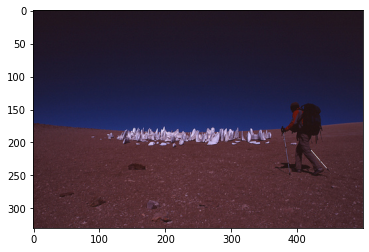

In [29]:
rid = np.random.randint(0, len(prepareDataset.img_name_val))
extract_caption(rid)

In [30]:
len(prepareDataset.img_name_val)

8091

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1 score: 21.428571428571423
BLEU-2 score: 12.838814775327384
BLEU-3 score: 1.47678845808219e-91
BLEU-4 score: 5.344839673067705e-153
Real Caption: two boys play with legos
Predicted Caption: two boys are sitting in front of statue with several paper in the background


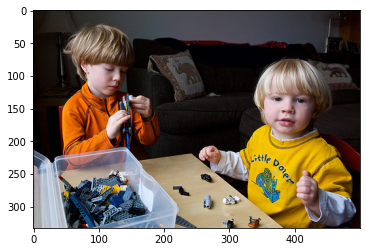

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1 score: 8.300915602566022
BLEU-2 score: 4.1067149252095696e-153
BLEU-3 score: 1.1389575472159276e-183
BLEU-4 score: 9.1343749725459e-230
Real Caption: girl and boy wearing swimming goggles have their arms around each other
Predicted Caption: two kids are smiling with the same mouth of their sunglasses


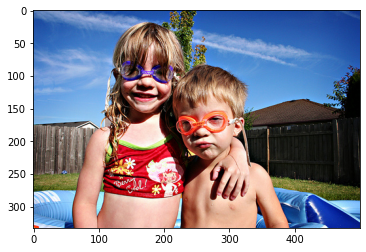

BLEU-1 score: 39.80729503187718
BLEU-2 score: 26.703545307500114
BLEU-3 score: 22.10578856248846
BLEU-4 score: 3.284457498899101e-76
Real Caption: man in red shirt riding trick bicycle on only the rear wheel
Predicted Caption: man in red outfit and shoes is on bicycle


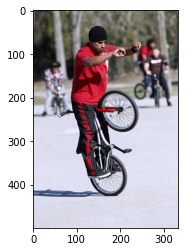

BLEU-1 score: 32.206169703226536
BLEU-2 score: 20.084075461628778
BLEU-3 score: 1.7229821612226873e-91
BLEU-4 score: 5.795035077445241e-153
Real Caption: one biker wearing black helmet riding on dirt hill
Predicted Caption: man is riding bicycle on dirt track


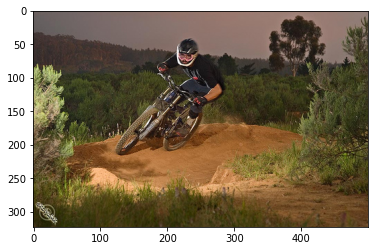

BLEU-1 score: 30.326532985631673
BLEU-2 score: 24.761510494160163
BLEU-3 score: 1.793125610102159e-91
BLEU-4 score: 5.780789590099596e-153
Real Caption: four kayakers paddle through the water
Predicted Caption: four kayakers on stream


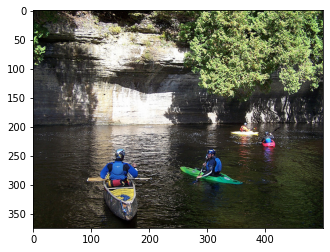

BLEU-1 score: 37.5
BLEU-2 score: 9.134564559628536e-153
BLEU-3 score: 1.9081654987219002e-183
BLEU-4 score: 1.4256605770826505e-229
Real Caption: seven older gentlemen walking together in group outside
Predicted Caption: group of seven people walking down the street


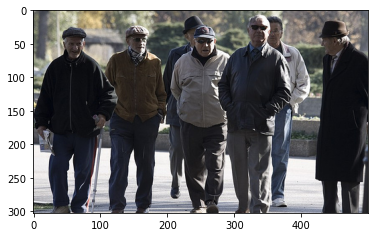

BLEU-1 score: 59.71094254781577
BLEU-2 score: 29.25226826055808
BLEU-3 score: 2.11832761107025e-91
BLEU-4 score: 6.829195976849488e-153
Real Caption: several people walking up ramp with blue handrail
Predicted Caption: people are walking up blue ramp


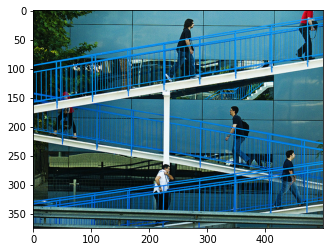

BLEU-1 score: 30.769230769230766
BLEU-2 score: 22.64554068289192
BLEU-3 score: 19.978910945001886
BLEU-4 score: 3.191385619211647e-76
Real Caption: photo of smiling young woman in front of tables on the street
Predicted Caption: young man with red hair and jacket is in front of brick building


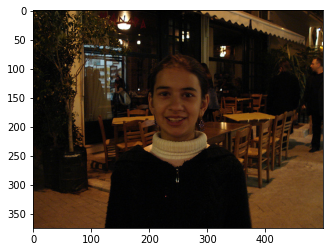

BLEU-1 score: 12.500000000000004
BLEU-2 score: 5.273843307431706e-153
BLEU-3 score: 1.372396692566494e-183
BLEU-4 score: 1.0832677820940878e-229
Real Caption: black labrador biting brown dogs neck
Predicted Caption: large black dog sniffs another dog behind it


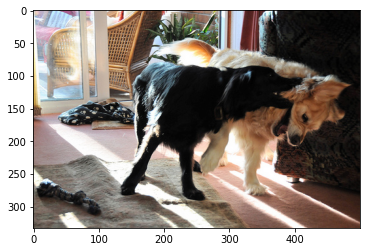

BLEU-1 score: 45.241870901797974
BLEU-2 score: 21.327222472151792
BLEU-3 score: 1.923942683267341e-91
BLEU-4 score: 6.552765724042392e-153
Real Caption: hockey player in red jersey taking drink out of sports bottle
Predicted Caption: hockey goalie in red uniform takes drink from water bottle


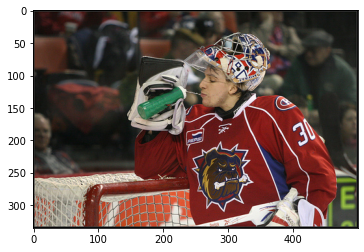

BLEU-1 score: 23.88437701912631
BLEU-2 score: 12.473209096354934
BLEU-3 score: 1.2702357167567957e-91
BLEU-4 score: 4.4594254026474683e-153
Real Caption: near window and chair young boy in blue shirt holds something in his hand and smiles
Predicted Caption: young boy wearing red and white shirt is holding birthday sports camera


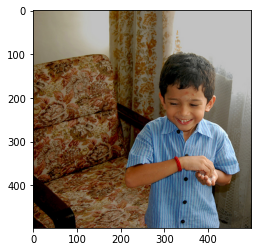

BLEU-1 score: 16.666666666666668
BLEU-2 score: 9.90147542976674
BLEU-3 score: 1.26363974695582e-91
BLEU-4 score: 4.693773976175812e-153
Real Caption: father feeding his child on the street
Predicted Caption: man in black shirt is taking nap on the phone of white and red blanket with his friend


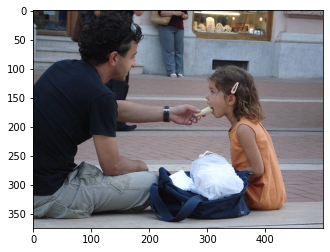

BLEU-1 score: 36.193496721438386
BLEU-2 score: 26.97703967085066
BLEU-3 score: 23.458368218182663
BLEU-4 score: 3.5879471085711125e-76
Real Caption: woman wearing blue shirt and hat with khaki shorts plays golf
Predicted Caption: woman in blue shirt and white shirt is taking swing


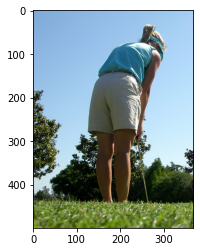

BLEU-1 score: 7.243303475117973
BLEU-2 score: 2.646576928737885e-153
BLEU-3 score: 6.502033690529349e-184
BLEU-4 score: 5.058927350602078e-230
Real Caption: wrestler is jumping off of the ring to hit his competitor
Predicted Caption: two men are wrestling in ring


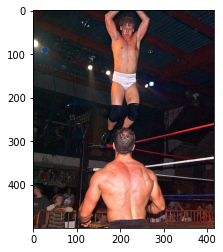

BLEU-1 score: 27.590958087858176
BLEU-2 score: 4.7523494257851955e-153
BLEU-3 score: 8.642324239134327e-184
BLEU-4 score: 6.237049021538533e-230
Real Caption: dog sits in the snow with tennis ball
Predicted Caption: dog plays with snow


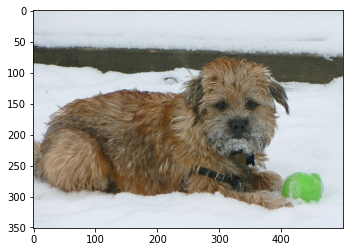

BLEU-1 score: 28.57142857142857
BLEU-2 score: 7.973301625706313e-153
BLEU-3 score: 1.7586776545063734e-183
BLEU-4 score: 1.331960397810445e-229
Real Caption: dog wearing collar jumping from platform
Predicted Caption: tan dog jumping off of the dock


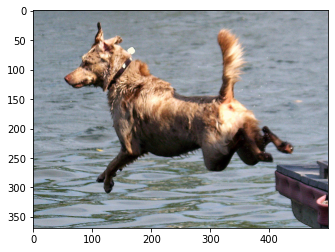

BLEU-1 score: 45.47743189500984
BLEU-2 score: 33.726966161676806
BLEU-3 score: 30.84874913241689
BLEU-4 score: 21.64869374624441
Real Caption: group shot of four guys and one girl in front of brick building
Predicted Caption: group of people pose for picture in front of brick house


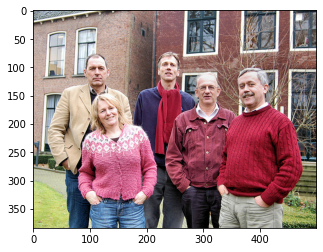

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: one boy pushes another on swing
Predicted Caption: two boys enjoy ride at something


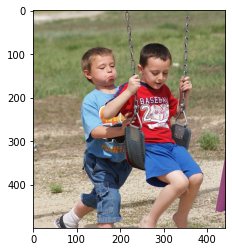

BLEU-1 score: 18.181818181818183
BLEU-2 score: 6.360494346864464e-153
BLEU-3 score: 1.5356698295026469e-183
BLEU-4 score: 1.1896457329133972e-229
Real Caption: the boy and girl are wearing swimming goggles
Predicted Caption: two kids are smiling with the same mouth of their sunglasses


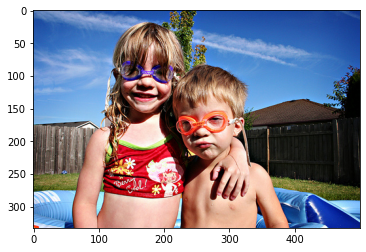

BLEU-1 score: 37.225089001774606
BLEU-2 score: 28.431131350350043
BLEU-3 score: 2.0046074122345223e-91
BLEU-4 score: 6.419573613943771e-153
Real Caption: brown dog runs in the grass with wooden fence behind
Predicted Caption: brown dog is running on the grass


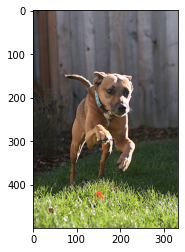

In [34]:
rnd_images=random.choices(range(0,len(prepareDataset.img_name_val)),k=20)
for rid in rnd_images:
  extract_caption(rid)